In [1]:
import numpy as np
import pandas as pd

# datasets
import aif360
from aif360.datasets import AdultDataset, BankDataset, CompasDataset, GermanDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
import folktables

# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# fair preprocessors
from aif360.algorithms.preprocessing import DisparateImpactRemover, LFR, Reweighing

# evaluation
## dataset evaluation
from aif360.metrics import BinaryLabelDatasetMetric
## classification metrics
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score, accuracy_score
from sklearn.metrics import mutual_info_score

# plots
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

2022-06-10 14:12:01.871565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-10 14:12:01.871599: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Fairness Evaluation Tool

This Notebook provides a tool for which algorithms can be compared to eachother with respect to classification metrics and fairness notions.
Let have $k$ machine learning models, i.e., $m_i$ with $i=1, \ldots, k$. We denote data as a set over triples, i.e., $D = \{(x_i, y_i, z_i)\}_i^n$ where $x_i$ describes the set of features, $y_i$ describes the label, and $z_i$ describes the protected attribute. The comparisons can each be done as follows:

- Preprocessing:
    - $\tilde{D} \leftarrow$ preprocess data $D$
    - Each model is fitted with both the observed and the preprocessed data. We denote $\tilde{m}_i$ for a model that has been fitted with $\tilde{D}$ and $m_i$ if it has been fitted with $D$.
    - We compare the predictions from each pair $(m_i(x), \tilde{m}_i(x))_1^k$
- Inprocessing:
    - For each model $m_i$, we employ the corresponding fair model $\tilde{m}_i$
    - We compare the predictions from each pair $(m_i(x), \tilde{m}_i(x))_1^k$
- Postprocessing:
    - Let $y$ be the true label, $\hat{y}$ be the unaltered prediction of the model $m_i$, and $\tilde{y}$ be the fair prediction, i.e., $\tilde{y} = \mu(m_i(x))$ where $\mu$ is the postprocessing method. Then we evaluate $(y, \hat{y})$ and $(y, \tilde{y})$ for all models.

If we plot the results w.r.t. accuracy and fairness notion, we can check whether a Pareto improvement was made when employing fairness methods. This is when the fair model $\tilde{m}_i$ achieves better results than the biased model $m_i$ in both accuracy and fairness.

## 1. Preparation

### 1.1. Dataset

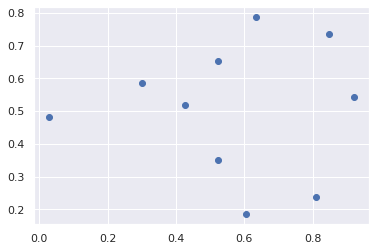

In [2]:
plt.scatter(np.random.rand(10), np.random.rand(10))

We use one dataset at this moment. Other datasets can be selected here.

In [3]:
def selecting_dataset(dataset_used: str, protected_attribute_used: str):
    """
    Parameters
    ----------
    dataset_used: str
    protected_attribute_used: str
    
    Returns
    -------
    dataset_orig: pandas DataFrame
    privileged_groups: list of dict
    unprivileged_groups: list of dict
    
    """
    
    if dataset_used == "adult":
        if protected_attribute_used == "sex":
            privileged_groups = [{'sex': 1}]
            unprivileged_groups = [{'sex': 0}]
            dataset_orig = load_preproc_data_adult(['sex'])
        elif protected_attribute_used == "race":
            privileged_groups = [{'race': 1}]
            unprivileged_groups = [{'race': 0}]
            dataset_orig = load_preproc_data_adult(['race'])
    elif dataset_used == "bank":
        if protected_attribute_used == "age":
            privileged_groups = [{'age': 1}]
            unprivileged_groups = [{'age': 0}]
            dataset_orig = BankDataset(protected_attribute_names=['age'])
    elif dataset_used == "compas":
        if protected_attribute_used == "sex":
            privileged_groups = [{'sex': 1}]
            unprivileged_groups = [{'sex': 0}]
            dataset_orig = load_preproc_data_compas(['sex'])
        elif protected_attribute_used == "race":
            privileged_groups = [{'race': 1}]
            unprivileged_groups = [{'race': 0}]
            dataset_orig = load_preproc_data_compas(['race'])
    elif dataset_used == "german":
        if protected_attribute_used == "sex":
            privileged_groups = [{'sex': 1}]
            unprivileged_groups = [{'sex': 0}]
            dataset_orig = load_preproc_data_german(['sex'])
        elif protected_attribute_used == "age":
            privileged_groups = [{'age': 1}]
            unprivileged_groups = [{'age': 0}]
            dataset_orig = load_preproc_data_german(['age'])
    
    return dataset_orig, privileged_groups, unprivileged_groups


#random seed
np.random.seed(1)

# import dataset
dataset_used = "adult" # "adult", "german", "compas", "bank"
protected_attribute_used = "race" # sex, age, race
dataset_orig, privileged_groups, unprivileged_groups = selecting_dataset(dataset_used, protected_attribute_used)
dataset_train, dataset_test = dataset_orig.split([0.7], shuffle=True)

### 1.2. Models (classifiers)

In [4]:
# initialize machine learning models
models = [LogisticRegression,
          #RandomForestClassifier,
          SVC,
          MLPClassifier]

## 2. Preprocessing

Preprocess the data.

1. Apply each preprocessing method to the dataset.

In [5]:
# initialize list of preprocessors
# Optimized Preproc. requires distortion functions
preprocessors = [DisparateImpactRemover(sensitive_attribute=protected_attribute_used),
                 #LFR(unprivileged_groups=unprivileged_groups,
                 #   privileged_groups=privileged_groups)]#,
                 Reweighing(unprivileged_groups=unprivileged_groups,
                            privileged_groups=privileged_groups)]

In [6]:
preproc_datasets = {type(preprocessor).__name__: preprocessor.fit_transform(dataset_train) for preprocessor in preprocessors}

An element of the preprocessed_datasets list contains the preprocessed datasets done by the specific preprocessing method.

## 3. Evaluation

### 3.1. Dataset Evaluation

AIF360 provides metrics to evaluate whether the dataset is fair. https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.BinaryLabelDatasetMetric.html

In [7]:
def get_BinaryLabelDatasetMetric(dataset_train, preproc_datasets,
                                 privileged_groups,
                                 unprivileged_groups):
    
    dataset_metric = BinaryLabelDatasetMetric(dataset_train,
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)

    preproc_dataset_metrics = {key: BinaryLabelDatasetMetric(preproc_datasets[key],
                                                             unprivileged_groups=unprivileged_groups,
                                                             privileged_groups=privileged_groups) for key in preproc_datasets}

    return dataset_metric, preproc_dataset_metrics

In [8]:
dataset_metric, preproc_dataset_metrics =\
                            get_BinaryLabelDatasetMetric(dataset_train,
                                                        preproc_datasets,
                                                        privileged_groups,
                                                        unprivileged_groups)

In [9]:
evaluate_dataset_metrics = lambda keyName, blDatasetMetric: pd.DataFrame({
    'Name': keyName,
    'Base Rate': blDatasetMetric.base_rate(),
    'Consistency': blDatasetMetric.consistency(),
    'Statistical Parity Difference': blDatasetMetric.statistical_parity_difference(),
    'Disparate Impact': blDatasetMetric.disparate_impact(),
    'Smoothed Empirical Differential Fairness': blDatasetMetric.smoothed_empirical_differential_fairness()
})

In [10]:
dataset_evaluation = evaluate_dataset_metrics('Dataset (Original)', dataset_metric)

In [11]:
all_dataset_evaluation = pd.concat([evaluate_dataset_metrics(key, value) for key, value in preproc_dataset_metrics.items()])
all_dataset_evaluation = pd.concat([dataset_evaluation, all_dataset_evaluation])

In [12]:
all_dataset_evaluation.head()

,Name,Base Rate,Consistency,Statistical Parity Difference,Disparate Impact,Smoothed Empirical Differential Fairness
0,Dataset (Original),0.237913,0.711065,-0.097036,0.615086,0.485582
0,DisparateImpactRemover,0.237913,0.711065,-0.097036,0.615086,0.485582
0,Reweighing,0.237913,0.711065,0.000000,1.000000,0.000183


In [13]:
#sns.scatterplot(data=all_dataset_evaluation, x="Statistical Parity Difference", y="Disparate Impact", hue='Name')

### 3.2. Classification Evaluation

#### 3.2.1. Training

In [14]:
# dataset preparation
X_train = dataset_train.features
y_train = dataset_train.labels.ravel()
Xs_preproc = {key: value.features for key, value in preproc_datasets.items()}
ys_preproc = {key: value.labels.ravel() for key, value in preproc_datasets.items()}

In [15]:
pipeline = lambda name, model: Pipeline([('scaler', StandardScaler()), (name, model)])

In [16]:
# create multiple models for each preprocessed dataset
models_trained = {type(model()).__name__:
                  {type(preprocessor).__name__: model() for preprocessor in preprocessors} for model in models}

In [17]:
# train models
for key_model, value_model in models_trained.items():
    for key_preproc in value_model:
        model = models_trained[key_model][key_preproc]
        models_trained[key_model][key_preproc] =\
                pipeline(type(model).__name__, model).fit(Xs_preproc[key_preproc], ys_preproc[key_preproc])

In [18]:
models_trained

{'LogisticRegression': {'DisparateImpactRemover': Pipeline(steps=[('scaler', StandardScaler()),
                  ('LogisticRegression', LogisticRegression())]),
  'Reweighing': Pipeline(steps=[('scaler', StandardScaler()),
                  ('LogisticRegression', LogisticRegression())])},
 'SVC': {'DisparateImpactRemover': Pipeline(steps=[('scaler', StandardScaler()), ('SVC', SVC())]),
  'Reweighing': Pipeline(steps=[('scaler', StandardScaler()), ('SVC', SVC())])},
 'MLPClassifier': {'DisparateImpactRemover': Pipeline(steps=[('scaler', StandardScaler()),
                  ('MLPClassifier', MLPClassifier())]),
  'Reweighing': Pipeline(steps=[('scaler', StandardScaler()),
                  ('MLPClassifier', MLPClassifier())])}}

#### 3.2.2. Evaluation on Preprocessed Testset

In [19]:
def calc_MI(x, y, bins=10):
    # discrimination measurement
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [20]:
X_test, y_test = dataset_test.features, dataset_test.labels.ravel()

# create results dictionary
results = {type(model()).__name__:
                  {type(preprocessor).__name__: {} for preprocessor in preprocessors} for model in models}

In [21]:
# evaluate the models
for key_model in models_trained:
    for key_preproc in models_trained[key_model]:
        # Classification Metric
        y_pred =\
            models_trained[key_model][key_preproc].predict(X_test)
        
        results[key_model][key_preproc]['F1 Score'] =\
            f1_score(y_test, y_pred)
        
        # Fairness Notion
        results[key_model][key_preproc]['Mutual Information'] =\
            calc_MI(y_test, y_pred)

In [22]:
results

{'LogisticRegression': {'DisparateImpactRemover': {'F1 Score': 0.4887868620872329,
   'Mutual Information': 0.06704140158053203},
  'Reweighing': {'F1 Score': 0.4887868620872329,
   'Mutual Information': 0.06704140158053203}},
 'SVC': {'DisparateImpactRemover': {'F1 Score': 0.4887868620872329,
   'Mutual Information': 0.06704140158053203},
  'Reweighing': {'F1 Score': 0.4887868620872329,
   'Mutual Information': 0.06704140158053203}},
 'MLPClassifier': {'DisparateImpactRemover': {'F1 Score': 0.4905329593267882,
   'Mutual Information': 0.06686108085099472},
  'Reweighing': {'F1 Score': 0.4936422226093015,
   'Mutual Information': 0.06738047471366393}}}

#### 3.2.3. Plot

In [23]:
plot_classifier = 'LogisticRegression'

In [24]:
def plot_error_discrimination(results, plot_classifier):
    # Single model + Multiple Preprocessor
    df = pd.DataFrame(results[plot_classifier]).transpose()
    df['Preprocessor'] = df.index
    sns.relplot(data=df, x='Mutual Information', y='F1 Score', hue='Preprocessor')

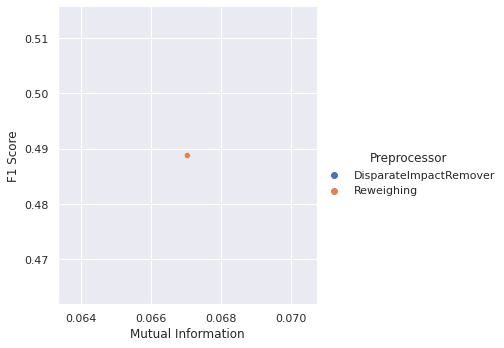

In [25]:
plot_error_discrimination(results, plot_classifier)

In [26]:
def results_to_df(results):
    df_list = []
    for key_model in results:
        df = pd.DataFrame(results[key_model]).transpose()
        df['Preprocessor'] = df.index
        
        df_list.append(df)
    
    df_concat = pd.concat(df_list, keys=list(results.keys()))
    df_concat['Model'] = df_concat.index
    df_concat = df_concat.reset_index()
    df_concat = df_concat.drop(columns = ['level_0', 'level_1'])
    
    return df_concat

In [27]:
df_plot = results_to_df(results)

In [28]:
df_plot

,F1 Score,Mutual Information,Preprocessor,Model
0,0.488787,0.067041,DisparateImpactRemover,"(LogisticRegression, DisparateImpactRemover)"
1,0.488787,0.067041,Reweighing,"(LogisticRegression, Reweighing)"
2,0.488787,0.067041,DisparateImpactRemover,"(SVC, DisparateImpactRemover)"
3,0.488787,0.067041,Reweighing,"(SVC, Reweighing)"
4,0.490533,0.066861,DisparateImpactRemover,"(MLPClassifier, DisparateImpactRemover)"
5,0.493642,0.067380,Reweighing,"(MLPClassifier, Reweighing)"


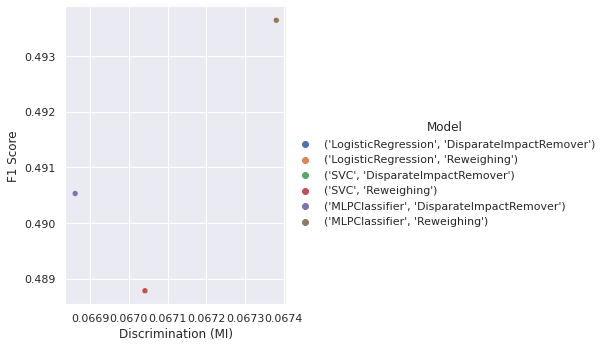

In [29]:
plot = sns.relplot(data=df_plot, x='Mutual Information', y='F1 Score', hue='Model')
plot.set_xlabels("Discrimination (MI)")
#plot.set(ylim=(0, 1))
#plot.set(xlim=(0, 1))